In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import psycopg2
import seaborn as sns

sns.set_style("whitegrid")
import statsmodels.formula.api as sm
from export_regression_lib import trained_model, odds_ratio, independent_variable_stats
from export_regression_lib import (
    standardized_features,
    simulating_features,
    simulate_continuous_outcomes,
)

/usr/local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# START HERE
## The cell below contains all the mission specific data. Here you will specifity, the independent variables, the dependent variable, and the definitions of positive and negative outcome.

In [4]:
# CHANGE THESE VALUES
# ONLY USE SINGLE QUESTIONS FOR DEPENDENT AND INDEPENDENT VARIABLES IN FORMAT 'PART_NUM-QUESTION_NUM'
continuous_independent_variables = ["Q30", "Q33", "Q36", "Q41"]
# NOTE MULTIPLE QUESTIONS NEED TO BE CATEGORICAL
categorical_independent_variables = ["Q35", "Q39", "Q42"]
# categorical_dict = {'Q39': 'Urban', 'Q42': 'Republican',  'Q43': 'Donald Trump'}
recoded_categorical_variables = {
    "Q35": {
        "Male": ["Male"],
        "Female": [],
    }
}
categorical_dict = {}
dependent_variable = "Q19_4"
negative_outcomes = ["3", "4"]
positive_outcomes = ["1", "2"]
grouping = "rid"

data_file_name = "data_files/hot_takes_data.csv"
encoded_file_name = "data_files/hot_takes_encoded.csv"

# After entering the information above, go to Cell -> Run All to see your regression results

In [5]:
data = pd.read_csv(data_file_name).drop([0,1])
encoded_data = pd.read_csv(encoded_file_name).drop([0,1])
continuous_data = encoded_data[continuous_independent_variables + ['rid', dependent_variable]].dropna()
for cat in categorical_independent_variables:
    data[cat] = data[cat].str.replace("\t"," ")
for cont in continuous_independent_variables + [dependent_variable]:
    continuous_data[cont] = continuous_data[cont].astype(int)

In [6]:
data['Q35'].unique()

array(['Male ', 'Female', 'Prefer not to identify',
       'Gender non-conforming / non-binary'], dtype=object)

In [7]:
dep_var = (
    pd.merge(
        data[['rid',dependent_variable]],
        encoded_data[['rid',dependent_variable]],
        on='rid'
    )
    .rename(columns={dependent_variable+'_x': 'Value', dependent_variable+'_y':'Encoding','rid':'count'})
    .groupby(['Value', 'Encoding'])
    .count().reset_index()
)
dep_var

,Value,Encoding,count
0,\tI somewhat do NOT want this to come true.,2,311
1,I definitely WANT this to come true.,4,156
2,I definitely do NOT want this to come true.,1,313
3,I somewhat WANT this to come true.,3,270


In [8]:
for cat in recoded_categorical_variables:
    recoded_vals = []
    for val in recoded_categorical_variables[cat]:
        print(val, not recoded_categorical_variables[cat][val], recoded_vals)
        print(val not in recoded_vals)
        print((not recoded_categorical_variables[cat][val]) and ('Male' not in recoded_vals))
        data[cat] = data.apply(
            lambda row: val
            if ((row[cat] in recoded_categorical_variables[cat][val])
            or (
                (not recoded_categorical_variables[cat][val])
                and (row[cat] not in recoded_vals)
            ))
            else row[cat],
            axis=1,
        )
        recoded_vals.append(val)

Male False []
True
False
Female True ['Male']
True
False


In [9]:
data['Q35'].unique()

array(['Female'], dtype=object)

In [10]:
for cat in recoded_categorical_variables:
    for val in recoded_categorical_variables[cat]:
        #print(val, recoded_categorical_variables[cat][val])
        data[cat] = data.apply(
            lambda row: val if row[cat] in recoded_categorical_variables[cat][val]
            else row[cat],
            axis=1
        )
if categorical_dict:
    pass
else:
    for f in categorical_independent_variables:
        temp_grpd = data[['rid',f]].groupby(f).count().reset_index()
        loc = temp_grpd['rid'].idxmax()
        categorical_dict[f] = temp_grpd[f].iloc[loc]

In [11]:
def get_outcome(response, positive_outcomes, negative_outcomes):
    if str(response) in positive_outcomes:
        return 1
    elif str(response) in negative_outcomes:
        return 0
    else:
        return None

In [12]:
dummy_df = pd.DataFrame()
for cat in categorical_independent_variables:
    temp_dummy_df = pd.get_dummies(data[["rid", cat]].dropna(), columns=[cat])
    if len(dummy_df) > 0:
        dummy_df = pd.merge(
            dummy_df,
            temp_dummy_df[
                [
                    col
                    for col in list(temp_dummy_df)
                    if not col.endswith(categorical_dict[cat])
                ]
            ],
            on="rid",
        )
    else:
        dummy_df = temp_dummy_df[
            [
                col
                for col in list(temp_dummy_df)
                if not col.endswith(categorical_dict[cat])
            ]
        ]
continuous_data['outcome'] = encoded_data.apply(
    lambda row: get_outcome(row[dependent_variable], positive_outcomes, negative_outcomes),
    axis=1
)
full_data = pd.merge(
    continuous_data,
    dummy_df,
    on='rid'
)
features = [f for f in list(full_data) if f not in ['rid', 'outcome', dependent_variable]]
categorical_features = [f for f in features if any([f.startswith(cf) for cf in categorical_independent_variables])]

In [13]:
full_data.corr()

,Q30,Q33,Q36,Q41,Q19_4,outcome,Q39_Rural,Q39_Urban,Q42_ Independent,Q42_Other,Q42_Republican
Q30,1.000000,-0.047654,-0.106538,0.011480,0.033786,-0.026366,0.045473,-0.128107,-0.027672,0.008174,0.018656
Q33,-0.047654,1.000000,0.436670,0.067751,0.096288,-0.098116,-0.189380,0.066675,-0.032840,-0.105677,0.053769
Q36,-0.106538,0.436670,1.000000,-0.009967,0.030782,-0.019883,-0.181875,-0.039996,-0.079975,-0.136930,0.166019
Q41,0.011480,0.067751,-0.009967,1.000000,-0.049523,0.034873,-0.086327,0.030065,0.000582,0.022842,-0.471690
Q19_4,0.033786,0.096288,0.030782,-0.049523,1.000000,-0.880938,0.008544,0.011379,-0.026787,-0.004477,0.078584
outcome,-0.026366,-0.098116,-0.019883,0.034873,-0.880938,1.000000,0.000458,-0.027741,0.024863,0.011442,-0.080516
Q39_Rural,0.045473,-0.189380,-0.181875,-0.086327,0.008544,0.000458,1.000000,-0.333707,0.067695,0.032291,0.090679
Q39_Urban,-0.128107,0.066675,-0.039996,0.030065,0.011379,-0.027741,-0.333707,1.000000,-0.068605,0.001709,-0.033889
Q42_ Independent,-0.027672,-0.032840,-0.079975,0.000582,-0.026787,0.024863,0.067695,-0.068605,1.000000,-0.126248,-0.365142
Q42_Other,0.008174,-0.105677,-0.136930,0.022842,-0.004477,0.011442,0.032291,0.001709,-0.126248,1.000000,-0.159874


In [14]:
full_data.groupby('outcome')['rid'].count().reset_index()

,outcome,rid
0,0.0,426
1,1.0,624


In [15]:
stats = independent_variable_stats(full_data, features)
full_data_std = standardized_features(full_data, continuous_independent_variables, stats)
len_pos = len(full_data_std[full_data_std['outcome'] == 1])
len_neg = len(full_data_std[full_data_std['outcome'] == 0])
sample_size = min(len_pos, len_neg)
training = pd.concat([
    full_data_std[full_data_std['outcome'] == 1].sample(n=sample_size),
    full_data_std[full_data_std['outcome'] == 0].sample(n=sample_size)
])
model = trained_model(training[features], training["outcome"])
model = trained_model(training[features], training["outcome"])

Optimization terminated successfully.
         Current function value: 0.683367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683367
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.683367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683367
  

In [16]:
print(model.summary())
sig_indicies = [i for i,p in enumerate(model.pvalues) if p <= .1]
sig_variables = [
        features[i]
        for i, col in enumerate(features)
        if i in sig_indicies
]
print("")
print("ODDS RATIOS~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(odds_ratio(model, sig_variables, sig_indicies))

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  852
Model:                          Logit   Df Residuals:                      843
Method:                           MLE   Df Model:                            8
Date:                Fri, 15 Feb 2019   Pseudo R-squ.:                 0.01411
Time:                        10:04:56   Log-Likelihood:                -582.23
converged:                       True   LL-Null:                       -590.56
                                        LLR p-value:                   0.03379
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Q30                  -0.0910      0.070     -1.291      0.197      -0.229       0.047
Q33                  -0.2345      0.078     -3.005      0.003      -0.388      -0.082
Q36                   0.

In [17]:
model.params

Q30                 -0.090956
Q33                 -0.234550
Q36                  0.104712
Q41                  0.027191
Q39_Rural            0.022388
Q39_Urban           -0.045475
Q42_ Independent     0.170795
Q42_Other            0.105079
Q42_Republican      -0.210229
dtype: float64

In [18]:
int(round(100 * (np.exp(-0.234550) - 1), 0))

-21

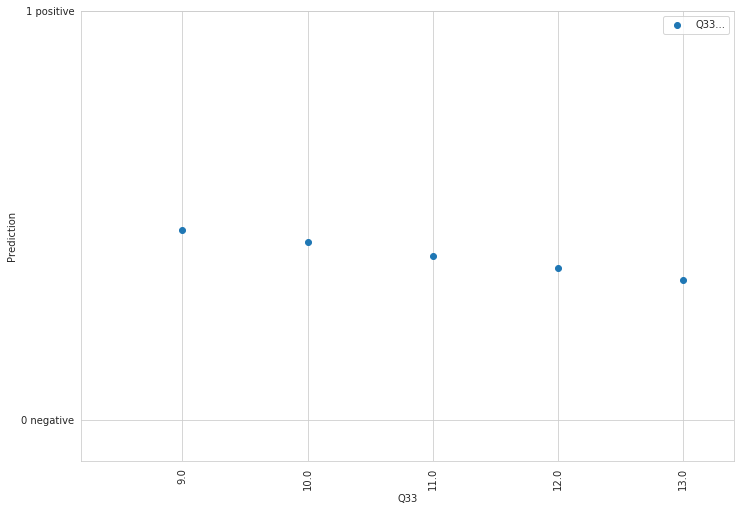

In [20]:
sns.set_style("whitegrid")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
simulated_features = simulating_features(full_data_std, features)
sig_indicies = [i for i, p in enumerate(model.pvalues) if p <= 0.10]
sig_variables = [
    features[i]
    for i, col in enumerate(features)
    if i in sig_indicies and col not in categorical_features
]
for independent_variable in sig_variables:
    outcome_labels = ["negative", "positive"]
    outcome_choices = [0, 1]
    r_d = simulate_continuous_outcomes(
        simulated_features, model, features, independent_variable
    )
    ax.scatter(
        r_d["response_range"],
        r_d["predictions"],
        label=independent_variable[0:20] + "...",
    )
    ax.set_ylabel("Prediction")
    ax.set_xlabel(independent_variable)
    ax.set_yticks(np.sort(outcome_choices))
    ax.set_yticklabels(
        [
            str(outcome) + " " + choice
            for outcome, choice in zip(outcome_choices, outcome_labels)
        ]
    )
    ax.set_xticks(np.sort(r_d["response_range"]))
    ax.set_xticklabels(
        [
            round(
                stats[independent_variable]["std"]
                * (stats[independent_variable]["mu"] + chc)
            )
            for chc in r_d["question_choices"]
        ],
        rotation=90,
    )
    ax.legend()
    ax.set_ylim(-0.1)
    ax.set_xlim(-0.1)
# plt.savefig("sig_sum_uses.png")
plt.show()

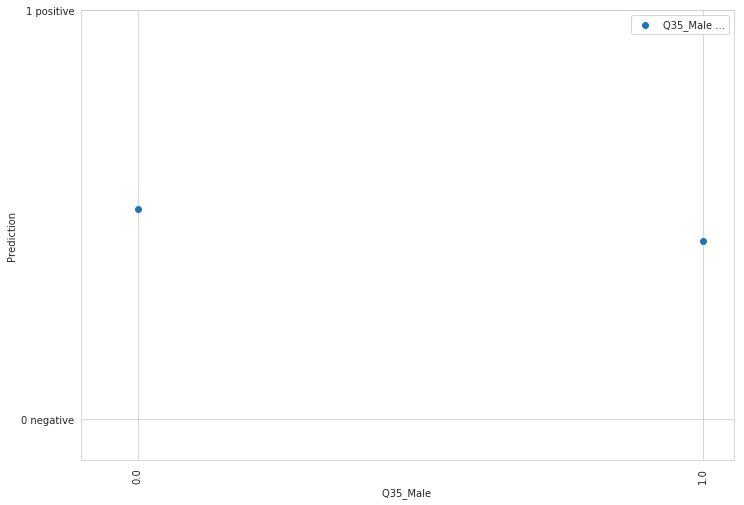

In [21]:
sns.set_style("whitegrid")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
simulated_features = simulating_features(full_data_std, features)
sig_indicies = [i for i, p in enumerate(model.pvalues) if p <= 0.10]
sig_variables = [
    features[i]
    for i, col in enumerate(features)
    if i in sig_indicies and col in categorical_features
]
for independent_variable in sig_variables:
    outcome_labels = ["negative", "positive"]
    outcome_choices = [0, 1]
    r_d = simulate_continuous_outcomes(
        simulated_features, model, features, independent_variable
    )
    ax.scatter(
        r_d["response_range"],
        r_d["predictions"],
        label=independent_variable[0:20] + "...",
    )
    ax.set_ylabel("Prediction")
    ax.set_xlabel(independent_variable)
    ax.set_yticks(np.sort(outcome_choices))
    ax.set_yticklabels(
        [
            str(outcome) + " " + choice
            for outcome, choice in zip(outcome_choices, outcome_labels)
        ]
    )
    ax.set_xticks(np.sort(r_d["response_range"]))
    ax.set_xticklabels(
        [
            round(
                stats[independent_variable]["std"]
                * (stats[independent_variable]["mu"] + chc)
            )
            for chc in r_d["question_choices"]
        ],
        rotation=90,
    )
    ax.legend()
    ax.set_ylim(-0.1)
    ax.set_xlim(-0.1)
# plt.savefig("sig_sum_uses.png")
plt.show()

In [22]:
mod = sm.OLS(full_data_std[[dependent_variable]], full_data_std[features]).fit()
mod = sm.OLS(full_data_std[[dependent_variable]], full_data_std[features]).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                  Q19_4   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     208.3
Date:                Tue, 08 Jan 2019   Prob (F-statistic):          2.78e-240
Time:                        12:34:05   Log-Likelihood:                -1868.3
No. Observations:                1050   AIC:                             3757.
Df Residuals:                    1040   BIC:                             3806.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Q30                   0.0759      0.04

In [23]:
full_data_std['Q33'].unique()

array([ 0.82454836, -1.22099394, -0.70960836,  0.31316278,  1.33593393,
       -0.19822279, -1.73237951,  2.35870508,  1.8473195 ])